In [1]:
#install requirements
%pip install -q -r requirements.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.1 requires nvidia-ml-py3==7.352.0, which is not installed.
jupyter-ai 2.28.3 requires faiss-cpu!=1.8.0.post0,<2.0.0,>=1.8.0, which is not installed.
autogluon-core 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.5.2 which is incompatible.
autogluon-core 1.1.1 requires scipy<1.13,>=1.5.4, but you have scipy 1.14.1 which is incompatible.
autogluon-features 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.5.2 which is incompatible.
autogluon-multimodal 1.1.1 requires jsonschema<4.22,>=4.18, but you have jsonschema 4.23.0 which is incompatible.
autogluon-multimodal 1.1.1 requires omegaconf<2.3.0,>=2.1.1, but you have omegaconf 2.3.0 which is incompatible.
autogluon-multimodal 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.5.2

In [1]:
# Environment setup
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()


False

In [2]:
import boto3
import os

session = boto3.Session(
    region_name=os.getenv("AWS_REGION", "us-east-1"), profile_name=os.getenv("AWS_PROFILE")
)
bedrock_client = boto3.client(
    service_name='bedrock-runtime',
    endpoint_url='https://bedrock-runtime.'+os.getenv('AWS_REGION', 'us-east-1')+'.amazonaws.com',
    )

In [3]:
import json

prompt = "Hello, world"

body = json.dumps({
    "max_tokens": 4096,
    "temperature": 0.5,
    "messages": [
        {"role": "user", "content": prompt}
    ],
    "anthropic_version": "bedrock-2023-05-31"
})

response = bedrock_client.invoke_model(body=body, modelId="anthropic.claude-3-haiku-20240307-v1:0")
response_body = json.loads(response.get("body").read())      
print(response_body['content'][0]['text'])

Hello! It's nice to meet you. How can I assist you today?


In [4]:
from langchain_community.chat_models import BedrockChat
from langchain.llms.bedrock import Bedrock

def get_llm(model_kwargs, model_id="anthropic.claude-3-haiku-20240307-v1:0"):
    """Creates the LLM object for the langchain conversational bedrock agent.
    Parameters:
        model_kwargs (dict): Dictionary of model_kwargs to be passed to the Bedrock model.
    Returns:
        langchain.llms.bedrock.Bedrock: Bedrock model
    """
    session = boto3.Session(
        region_name=os.getenv("AWS_REGION", "us-east-1"), profile_name=os.getenv("AWS_PROFILE")
    )
    bedrock_client = boto3.client(
        service_name='bedrock-runtime',
        endpoint_url='https://bedrock-runtime.'+os.getenv('AWS_REGION', 'us-east-1')+'.amazonaws.com',
        )
    if (model_id == "anthropic.claude-3-haiku-20240307-v1:0") or (model_id == "anthropic.claude-3-sonnet-20240229-v1:0"):
        llm = BedrockChat(
            client=bedrock_client,
            model_id=model_id,
            model_kwargs=model_kwargs)
    else:
        llm = Bedrock(
            client=bedrock_client,
            model_id=model_id,
            model_kwargs=model_kwargs)

    return llm

In [5]:
# Let us test with 2 different models that have different APIs to access to show that Langchain can help abstract this away and always call the model the same way

import time
llm = get_llm(model_id="anthropic.claude-v2:1", model_kwargs={"max_tokens_to_sample": 4096,"temperature": 0.1})
llm_2 = get_llm(model_id="anthropic.claude-3-haiku-20240307-v1:0", model_kwargs={"max_tokens": 4096,"temperature": 0.1})

# For Claude 2.1
start_time = time.time()
response = llm.invoke("Tell me about the top 3 trends in Industrial Manufacturing")
end_time = time.time()
execution_time = end_time - start_time
print("Claude 2.1\n\n" + response)
print(f"\nExecution time: {execution_time:.2f} seconds\n\n")

# For Claude 3 Haiku
start_time2 = time.time()
response2 = llm_2.invoke("Tell me about the top 3 trends in Industrial Manufacturing")
end_time2 = time.time()
execution_time2 = end_time2 - start_time2
print("\n\nClaude 3 Haiku \n\n" + response2.content)
print(f"\nExecution time: {execution_time2:.2f} seconds")


Claude 2.1

 Here are three of the top trends in industrial manufacturing:

1. Smart manufacturing and Industry 4.0. This involves using advanced technologies like AI, automation, internet of things (IoT), and big data analytics to make manufacturing more efficient, productive, and responsive. Key innovations include smart factories, industrial IoT, advanced robotics, and predictive maintenance.

2. Sustainable manufacturing. Manufacturers are focusing more on sustainability - reducing waste, energy consumption, and carbon footprint through strategies like renewable energy, circular economy (reuse and recycling), responsible sourcing, and "green" supply chains. Many companies see sustainability as both a social responsibility and a competitive advantage.

3. Advanced materials and additive manufacturing. Manufacturers are adopting advanced materials like composites, nanomaterials, smart textiles to make lighter, stronger and more functional products. Additive manufacturing (3D printing

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer().fit_transform([response, response2.content])
similarity = cosine_similarity(vectorizer[0:1], vectorizer[1:2])
print(f"Similarity between responses: {similarity[0][0]:.2f}")


Similarity between responses: 0.64


In [7]:
!pip install TextBlob
from textblob import TextBlob

sentiment_1 = TextBlob(response).sentiment
sentiment_2 = TextBlob(response2.content).sentiment
print("Claude 2.1 Sentiment:", sentiment_1)
print("Claude 3 Haiku Sentiment:", sentiment_2)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 48.2 MB/s eta 0:00:00
Claude 2.1 Sentiment: Sentiment(polarity=0.2786139455782313, subjectivity=0.47393707482993186)
Claude 3 Haiku Sentiment: Sentiment(polarity=0.061974789915966375, subjectivity=0.5506302521008404)


In [8]:
prompts = [
    "Explain Automation and Robotics",
    "Explain Digital Transformation and Industry 4.0",
    "Explain Sustainability and Environmental Responsibility"
]

results = []
for prompt in prompts:
    start = time.time()
    res = llm.invoke(prompt)
    end = time.time()
    results.append({"prompt": prompt, "response": res, "execution_time": end - start})


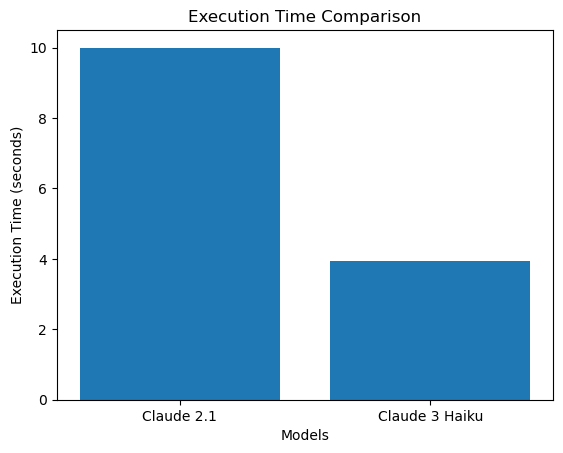

In [9]:
import matplotlib.pyplot as plt

prompts = ["Prompt 1", "Prompt 2", "Prompt 3"]
exec_times = [execution_time, execution_time2]

plt.bar(["Claude 2.1", "Claude 3 Haiku"], exec_times)
plt.xlabel("Models")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time Comparison")
plt.show()


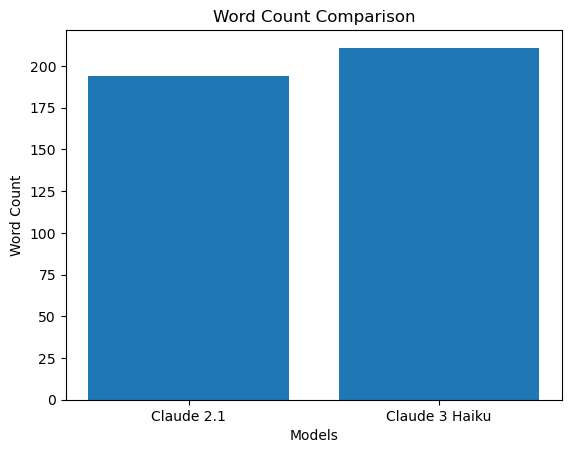

In [10]:
word_count_1 = len(response.split())
word_count_2 = len(response2.content.split())

plt.bar(["Claude 2.1", "Claude 3 Haiku"], [word_count_1, word_count_2])
plt.xlabel("Models")
plt.ylabel("Word Count")
plt.title("Word Count Comparison")
plt.show()


In [11]:
!pip install textstat

from textstat import flesch_reading_ease

readability_1 = flesch_reading_ease(response)
readability_2 = flesch_reading_ease(response2.content)
print("Readability Score for Claude 2.1:", readability_1)
print("Readability Score for Claude 3 Haiku:", readability_2)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 79.7 MB/s eta 0:00:00
Readability Score for Claude 2.1: 12.83
Readability Score for Claude 3 Haiku: 2.04


In [12]:
response_multilingual = llm.invoke("Expliquez les tendances actuelles dans la fabrication industrielle.")
print("Claude 2.1 (French):", response_multilingual)


Claude 2.1 (French):  Voici quelques-unes des principales tendances actuelles dans la fabrication industrielle :

- Automatisation et robotique : Les usines utilisent de plus en plus de robots, de cobots (robots collaboratifs), de machines automatisées et d'intelligence artificielle pour améliorer la productivité, la qualité et la sécurité. Cela réduit aussi les coûts de main-d'œuvre.

- Fabrication additive : Les imprimantes 3D et d'autres technologies de fabrication additive permettent de produire des pièces et des produits complexes sans moules ni outils. Cela permet une plus grande personnalisation et flexibilité. La fabrication additive devient de plus en plus utilisée pour la production en série.

- Internet industriel des objets (IIoT) : De plus en plus de capteurs et de logiciels sont utilisés dans la production pour collecter et analyser des données en temps réel, améliorer les processus et prédire la maintenance. L'IIoT connecte les équipements de l'usine numériquement.

- Fa

In [13]:
prompt_with_examples = """
Example 1: What are the benefits of AI? -> AI enables automation and improves efficiency.
Example 2: Explain cloud computing. -> Cloud computing is the delivery of computing services over the internet.
Now, explain industrial manufacturing trends.
"""
response_few_shot = llm.invoke(prompt_with_examples)
print(response_few_shot)


 Here is an explanation of some key industrial manufacturing trends:

1. Automation and robotics - Manufacturers are increasingly adopting automation technologies like robots, conveyor systems, and automated machinery. This allows faster production, reduced labor costs, and improved quality control.

2. Advanced analytics and AI - Manufacturers are utilizing big data analytics, machine learning, and artificial intelligence to derive insights from production data. This enables predictive maintenance of equipment, optimization of supply chains, and customization of production.

3. Sustainable manufacturing - There is a rise in use of renewable materials, reduction of waste, recycling, and adoption of energy efficient equipment. This allows manufacturers to reduce environmental impact and costs.

4. Smart connected factories - Manufacturing equipment and systems are becoming more connected through internet of things (IoT) devices and sensors. This allows real-time monitoring, coordination

In [14]:
long_prompt = "Write a detailed report on the impact of robotics in industrial manufacturing."
long_response = llm.invoke(long_prompt)
print(long_response)


 Here is a detailed report on the impact of robotics in industrial manufacturing:

Introduction

Robotics has had a significant impact on industrial manufacturing over the past few decades. As robots have become more advanced, affordable, and capable of performing complex tasks, manufacturers have increasingly adopted robotic automation in their production processes. This report explores the key impacts robotics has had on manufacturing in areas such as:

- Productivity and Efficiency
- Product Quality 
- Cost Reduction
- Workplace Safety
- Job Creation
- Workforce Displacement

Increased Productivity and Efficiency

One of the biggest impacts of robotics has been substantially increased productivity and efficiency in manufacturing facilities. Robots can operate 24/7 without breaks, perform tasks with a higher degree of accuracy and repeatability, and often at faster speeds than human workers. This results in higher throughput and output. Industrial robots have been estimated to increa

In [15]:
summary_prompt= "Write a summary of your response to the report on the impact of robotics in industrial manufacturing."
summary_response = llm.invoke(summary_prompt)
print(summary_response)


 Unfortunately I do not have enough context to generate a summary. As an AI assistant without access to previous conversations or documents, I do not have any information about a report on the impact of robotics in industrial manufacturing or any response I may have provided. I'd be happy to summarize such a response if you provide me some more details about the original report and what my response contained. Please feel free to provide additional context, and I apologize that I am unable to be more helpful at this time.


In [16]:
adv_prompt = "Write a detailed report on the impact of robotics in industrial manufacturing."
adv_response = llm_2.invoke(adv_prompt)
print(adv_response)

content='Certainly! Here is a detailed report on the impact of robotics in industrial manufacturing:\n\nIntroduction:\nThe integration of robotics in industrial manufacturing has been a transformative force, revolutionizing the way products are designed, produced, and delivered. Robotics has become an essential component of modern manufacturing, offering a wide range of benefits that have significantly impacted the industry.\n\nIncreased Productivity and Efficiency:\nOne of the primary impacts of robotics in industrial manufacturing is the significant increase in productivity and efficiency. Robotic systems can work tirelessly, with high precision and speed, outperforming human workers in repetitive tasks. This has led to a substantial increase in output, reduced production times, and improved overall equipment effectiveness (OEE).\n\nImproved Quality and Consistency:\nRobotic systems are programmed to perform tasks with a high degree of accuracy and consistency, ensuring that the fina

In [17]:
sumary_prompt = "Write a summary of the detailed report on the impact of robotics in industrial manufacturing you just gave."
sumary_response = llm_2.invoke(sumary_prompt)
print(sumary_response)

content="Unfortunately, I do not have access to any detailed report on the impact of robotics in industrial manufacturing. As an AI assistant without specific knowledge about such a report, I do not have a summary to provide. If you are able to share the detailed report you mentioned, I would be happy to review it and provide a concise summary of the key points and findings. Please let me know if you can provide the report, and I'll do my best to summarize it for you."
